# 04 - Comparativa final (_Baselines_ vs modelo propuesto)

En este cuaderno se expone la comparativa final entre el modelo de aprendizaje automático propuesto y los modelos de referencia.

## 1. Imports y configuración

In [1]:
import json
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

pd.set_option("display.max_columns", 200)

PROJECT_ROOT  = Path("..")
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
FIG_DIR = ARTIFACTS_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

BASELINES_JSON = ARTIFACTS_DIR / "baselines_detailed.json"
FINAL_META_GLOB = ARTIFACTS_DIR / "final_model" / "final_model_meta.json"

TEST_DAYS = ["2025-04-11", "2025-04-20", "2025-10-07"]

In [2]:
mpl.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
})

MODEL_LABELS = {
    "A_Physical_Simulation": "Baseline A — Simulación física normalizada",
    "B_ClearSky": "Baseline B — Clear-sky (GHI)",
    "C_XGBoost_Meteo": "Baseline C — Solo meteo (XGBoost)",
    "Final (sim+ML)": "Modelo final (sim + ML)",
    "Final_sim_ML": "Modelo final (sim + ML)",
}

COL_LABELS = {
    "global_r2": "R² global",
    "global_rmse": "RMSE global (W/m²)",
    "global_mae": "MAE global (W/m²)",
    "global_mbe": "MBE global (W/m²)",
    "n_train": "Muestras train",
    "n_test": "Muestras test",
    "model": "Modelo",
}

def pretty_model(name: str) -> str:
    return MODEL_LABELS.get(name, name)

## 2. Utilidades de carga y normalización

In [3]:
def load_json(path: Path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

In [4]:
def meta_to_flat_row(meta: dict, model_name: str = "Final (sim+ML)"):
    """
    Convierte model_final_meta.json a una fila compatible con baselines_results.csv
    """
    g = meta.get("metrics_global", {})
    row = {
        "model": model_name,
        "n_train": meta.get("n_train", np.nan),
        "n_test": meta.get("n_test", np.nan),
        "global_r2": g.get("r2", np.nan),
        "global_mae": g.get("mae", np.nan),
        "global_rmse": g.get("rmse", np.nan),
        "global_mbe": g.get("mbe", np.nan),
    }

    for drow in meta.get("metrics_by_day", []):
        d = drow.get("date")
        if not d:
            continue
        row[f"{d}_rmse"] = drow.get("rmse", np.nan)
        row[f"{d}_mae"]  = drow.get("mae", np.nan)
        row[f"{d}_r2"]   = drow.get("r2", np.nan)
        row[f"{d}_mbe"]  = drow.get("mbe", np.nan)

    return row

In [5]:
def styled_metrics_table(df: pd.DataFrame, caption: str):
    return (
        df.style
        .format({
            "global_r2": "{:.3f}",
            "global_rmse": "{:.1f}",
            "global_mae": "{:.1f}",
            "global_mbe": "{:.1f}",
        }, na_rep="—")
        .set_caption(caption)
    )

## 3. Carga de resultados

In [6]:
# --- Baselines (A,B,C) ---
baselines = load_json(BASELINES_JSON)
rows_base = [meta_to_flat_row(b, model_name=b.get("model","Baseline")) for b in baselines]
df_base = pd.DataFrame(rows_base)

# --- Final model meta (latest iteration meta json) ---
candidates = sorted(FINAL_META_GLOB.parent.glob(FINAL_META_GLOB.name))
if len(candidates) == 0:
    raise FileNotFoundError(f"No se encontró ningún meta en: {FINAL_META_GLOB}")
FINAL_META = max(candidates, key=lambda p: p.stat().st_mtime)
meta_final = load_json(FINAL_META)
row_final = meta_to_flat_row(meta_final, model_name="Final (sim+ML)")

df_all = pd.concat([df_base, pd.DataFrame([row_final])], ignore_index=True)
df_all = df_all.sort_values("global_rmse", ascending=True).reset_index(drop=True)

print(f"[OK] Baselines loaded from: {BASELINES_JSON}")
print(f"[OK] Final meta loaded from: {FINAL_META}")
df_all

[OK] Baselines loaded from: ..\artifacts\baselines_detailed.json
[OK] Final meta loaded from: ..\artifacts\final_model\final_model_meta.json


,model,n_train,n_test,global_r2,global_mae,global_rmse,global_mbe,2025-04-11_rmse,2025-04-11_mae,2025-04-11_r2,2025-04-11_mbe,2025-04-20_rmse,2025-04-20_mae,2025-04-20_r2,2025-04-20_mbe,2025-10-07_rmse,2025-10-07_mae,2025-10-07_r2,2025-10-07_mbe
0,Final (sim+ML),12028.0,5400.0,0.833059,67.817693,123.831773,-0.033608,111.130836,65.862713,0.767564,21.619901,181.064911,120.140291,0.686922,-21.722550,29.467932,17.450074,0.990320,0.001825
1,C_XGBoost_Meteo,NaN,NaN,0.711023,105.014294,157.136213,-14.685819,143.256856,91.438242,0.643614,-26.797306,201.635657,140.352378,0.539512,-0.191972,102.668991,78.702114,0.820828,-17.937338
2,B_ClearSky,NaN,NaN,0.085571,198.992785,279.524385,119.692564,404.115335,334.134082,-1.835964,318.553341,227.953246,183.688842,0.411462,68.280559,105.131203,61.428923,0.812131,-48.429251
3,A_Physical_Simulation,NaN,NaN,-0.112597,212.943101,308.328537,157.413120,447.395227,368.381827,-2.475944,356.895820,267.374124,210.393670,0.190304,105.954025,44.153546,36.845418,0.966862,-11.369479


## 4. Tabla comparativa global

In [7]:
tbl_global = pd.DataFrame({
    "Modelo": df_all["model"].apply(pretty_model),
    "R² global": df_all["global_r2"],
    "RMSE global (W/m²)": df_all["global_rmse"],
    "MAE global (W/m²)": df_all["global_mae"],
    "MBE global (W/m²)": df_all["global_mbe"],
    "Muestras train": df_all["n_train"],
    "Muestras test": df_all["n_test"],
})

tbl_global = tbl_global.sort_values("RMSE global (W/m²)", ascending=True)

display(
    tbl_global.style
    .format({
        "R² global": "{:.3f}",
        "RMSE global (W/m²)": "{:.1f}",
        "MAE global (W/m²)": "{:.1f}",
        "MBE global (W/m²)": "{:.1f}",
        "Muestras train": "{:.0f}",
        "Muestras test": "{:.0f}",
    }, na_rep="—")
    .set_caption("Comparativa global de modelos")
)


,Modelo,R² global,RMSE global (W/m²),MAE global (W/m²),MBE global (W/m²),Muestras train,Muestras test
0,Modelo final (sim + ML),0.833,123.8,67.8,-0.0,12028,5400
1,Baseline C — Solo meteo (XGBoost),0.711,157.1,105.0,-14.7,—,—
2,Baseline B — Clear-sky (GHI),0.086,279.5,199.0,119.7,—,—
3,Baseline A — Simulación física normalizada,-0.113,308.3,212.9,157.4,—,—


## 5. Plots globales (RMSE y R²)

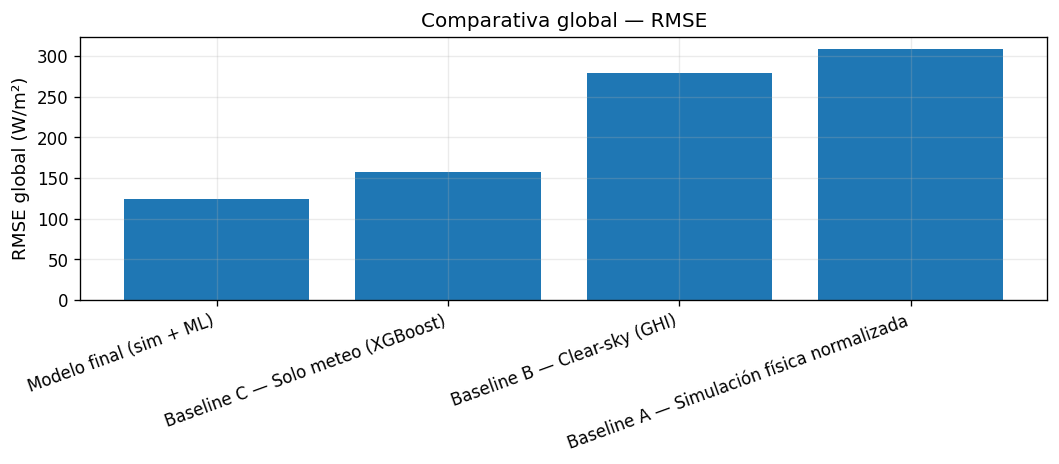

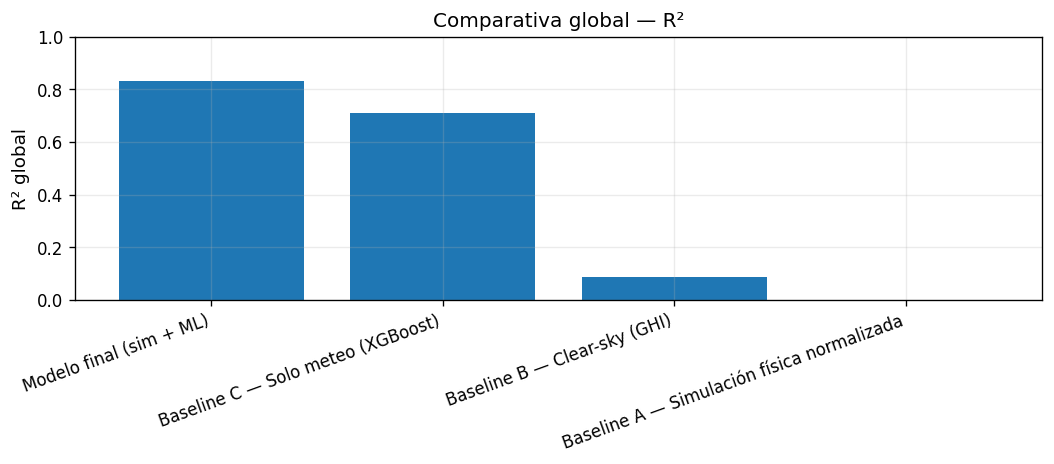

In [8]:
df_plot = df_all.copy()
df_plot["model_pretty"] = df_plot["model"].map(pretty_model)

plt.figure(figsize=(9, 4))
plt.bar(df_plot["model_pretty"], df_plot["global_rmse"])
plt.ylabel("RMSE global (W/m²)")
plt.title("Comparativa global — RMSE")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 4))
plt.bar(df_plot["model_pretty"], df_plot["global_r2"])
plt.ylabel("R² global")
plt.title("Comparativa global — R²")
plt.xticks(rotation=20, ha="right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()



## 6. Comparativa por día

,model_label,2025-04-11_r2,2025-04-11_rmse,2025-04-11_mae,2025-04-11_mbe
0,Modelo final (sim + ML),0.768,111.1,65.9,21.6
1,Baseline C — Solo meteo (XGBoost),0.644,143.3,91.4,-26.8
2,Baseline B — Clear-sky (GHI),-1.836,404.1,334.1,318.6
3,Baseline A — Simulación física normalizada,-2.476,447.4,368.4,356.9


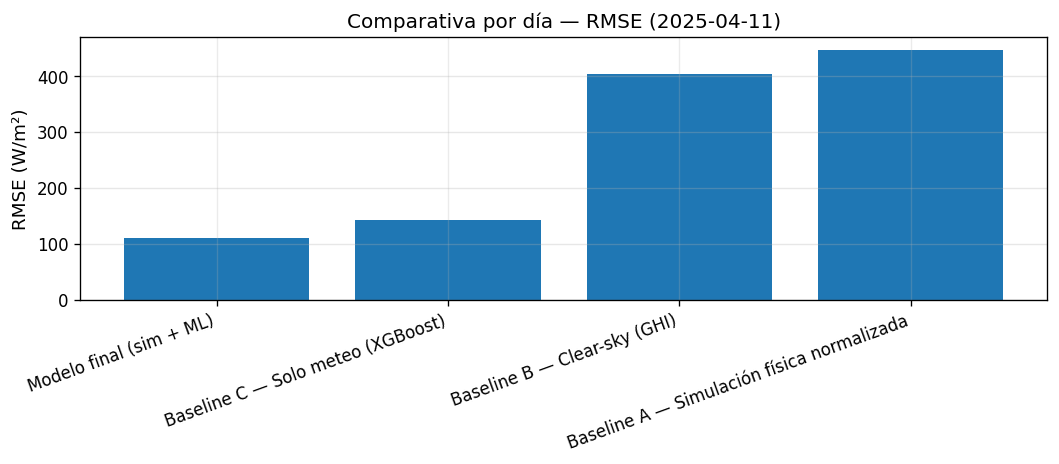

,model_label,2025-04-20_r2,2025-04-20_rmse,2025-04-20_mae,2025-04-20_mbe
0,Modelo final (sim + ML),0.687,181.1,120.1,-21.7
1,Baseline C — Solo meteo (XGBoost),0.540,201.6,140.4,-0.2
2,Baseline B — Clear-sky (GHI),0.411,228.0,183.7,68.3
3,Baseline A — Simulación física normalizada,0.190,267.4,210.4,106.0


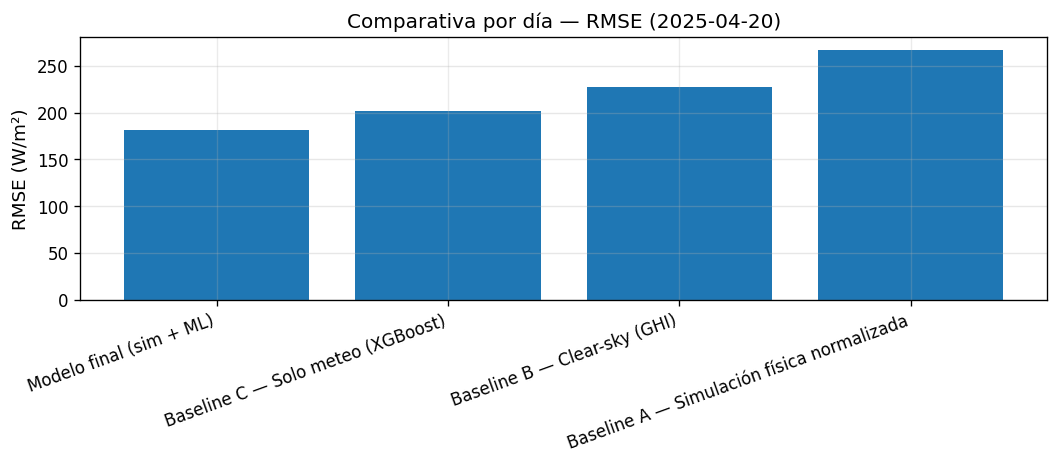

,model_label,2025-10-07_r2,2025-10-07_rmse,2025-10-07_mae,2025-10-07_mbe
0,Modelo final (sim + ML),0.990,29.5,17.5,0.0
1,Baseline A — Simulación física normalizada,0.967,44.2,36.8,-11.4
2,Baseline C — Solo meteo (XGBoost),0.821,102.7,78.7,-17.9
3,Baseline B — Clear-sky (GHI),0.812,105.1,61.4,-48.4


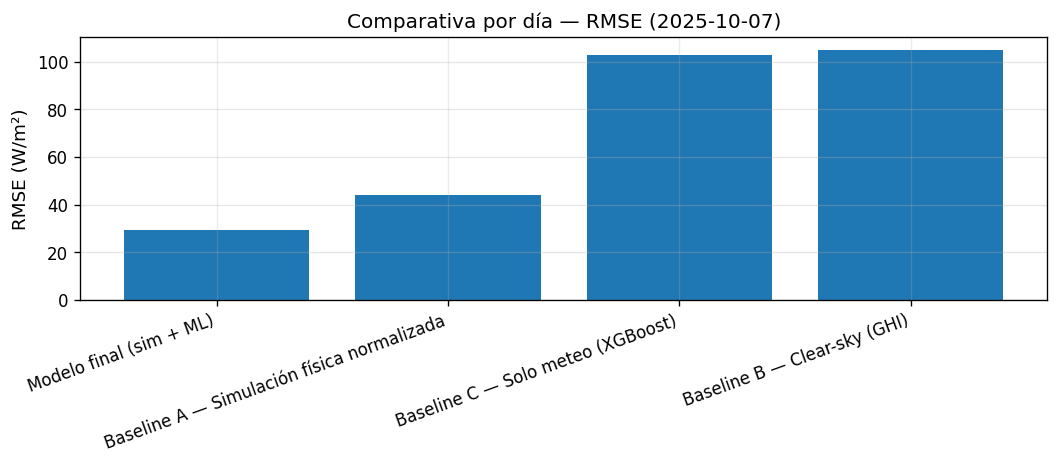

In [9]:
def by_day_table(df: pd.DataFrame, day: str) -> pd.DataFrame:
    cols = ["model", f"{day}_r2", f"{day}_rmse", f"{day}_mae", f"{day}_mbe"]
    out = df[cols].copy()
    out = out.sort_values(f"{day}_rmse", ascending=True).reset_index(drop=True)
    return out

for day in TEST_DAYS:
    df_day = by_day_table(df_all, day)

    df_day["model_label"] = df_day["model"].apply(pretty_model)

    # ---------- Table ----------
    display(
        df_day[["model_label", f"{day}_r2", f"{day}_rmse", f"{day}_mae", f"{day}_mbe"]]
        .style
        .format({
            f"{day}_r2": "{:.3f}",
            f"{day}_rmse": "{:.1f}",
            f"{day}_mae": "{:.1f}",
            f"{day}_mbe": "{:.1f}",
        }, na_rep="—")
        .set_caption(f"Comparativa por día — {day} (ordenado por RMSE)")
    )

    # ---------- Bar plot ----------
    plt.figure(figsize=(9, 4))
    plt.bar(df_day["model_label"], df_day[f"{day}_rmse"])
    plt.ylabel("RMSE (W/m²)")
    plt.title(f"Comparativa por día — RMSE ({day})")
    plt.xticks(rotation=20, ha="right")
    plt.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()


## 7. Series temporales comparativas

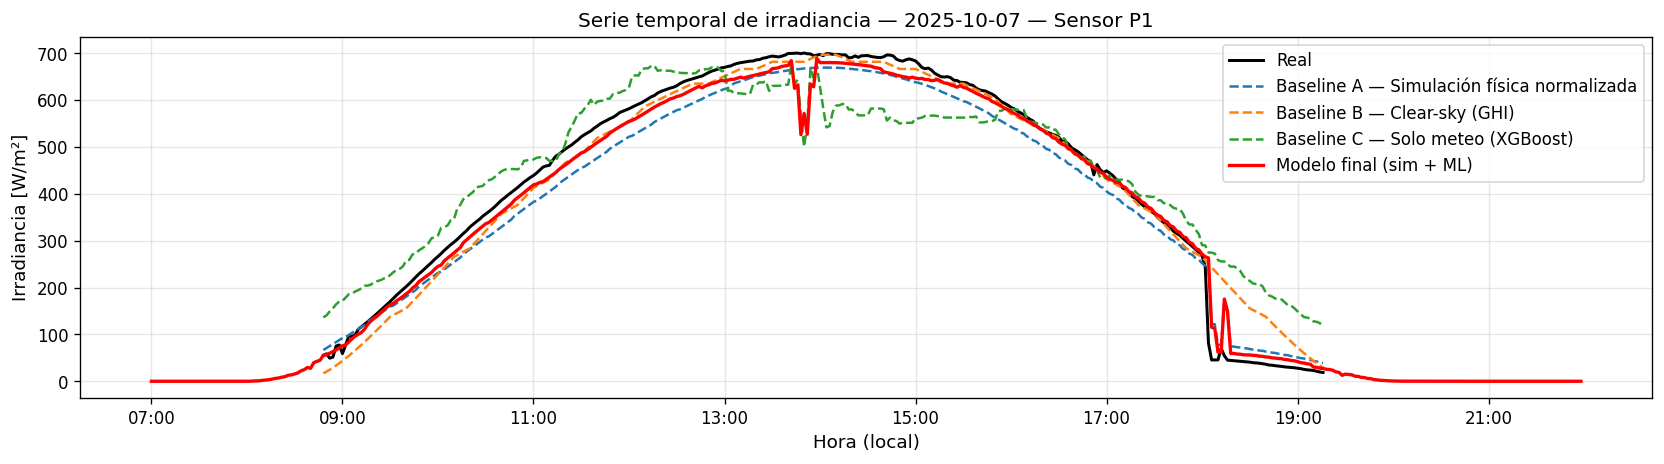

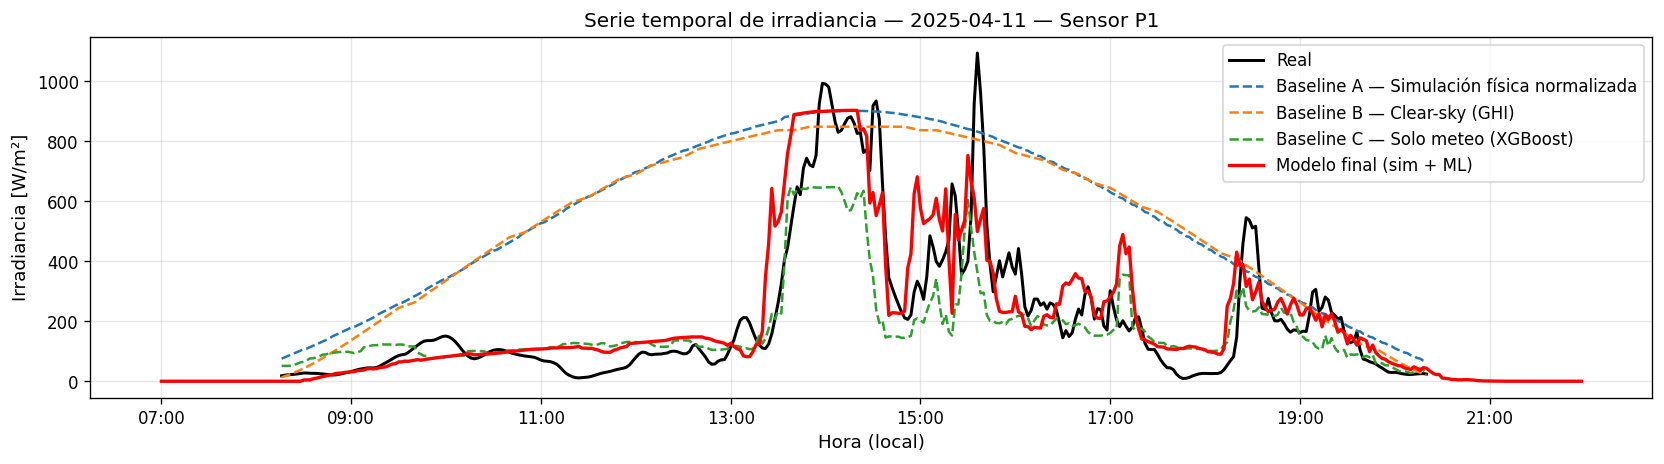

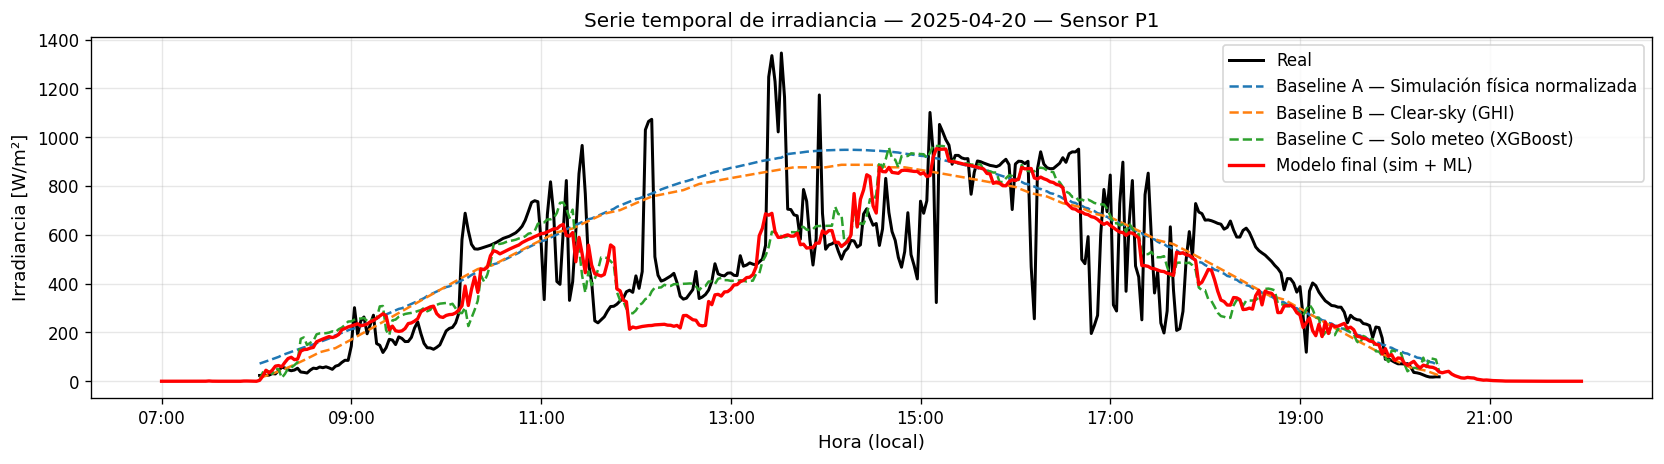

In [10]:
DAYS_TO_PLOT = ["2025-10-07", "2025-04-11", "2025-04-20"]
SENSOR_NAME = "P1"

MODELS = [
    "A_Physical_Simulation",
    "B_ClearSky",
    "C_XGBoost_Meteo",
]

FINAL_MODEL_LABEL = "Final_sim_ML"
FINAL_PREDS_PATTERN = "preds_{}_{}.csv" 

PROJECT_ROOT = Path("..")
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts" / "predictions"


def _sanitize_label(s: str) -> str:
    return "".join(ch if ch.isalnum() or ch in ("_", "-") else "_" for ch in s)


def load_preds_csv(path: Path) -> pd.DataFrame:
    """
    Carga un CSV de predicciones y trata de reconstruir un índice temporal si existe.
    Soporta: timestamp, utc, datetime, time, Unnamed: 0
    """
    if not path.exists():
        raise FileNotFoundError(f"No existe: {path}")

    df = pd.read_csv(path)

    time_candidates = ["timestamp", "utc", "datetime", "time", "Unnamed: 0"]
    time_col = next((c for c in time_candidates if c in df.columns), None)

    if time_col is not None:
        ts = pd.to_datetime(df[time_col], errors="coerce", utc=True)
        if ts.notna().sum() > 0:
            df = df.drop(columns=[time_col])
            df.index = ts
            df = df.sort_index()

    return df


def filter_sensor(df: pd.DataFrame, sensor_name: str) -> pd.DataFrame:
    """
    Filtra por sensor:
    - sensor_name (nuevo export del final)
    - sensor (si existe)
    - dummies sensor_P1, etc.
    """
    if "sensor_name" in df.columns:
        return df[df["sensor_name"].astype(str) == str(sensor_name)].copy()

    if "sensor" in df.columns:
        return df[df["sensor"].astype(str) == str(sensor_name)].copy()

    col = f"sensor_{sensor_name}"
    if col in df.columns:
        return df[df[col] == 1].copy()

    return df.copy()


def _dedup_time_index_for_plot(df: pd.DataFrame) -> pd.DataFrame:
    """
    Evita el efecto 'peine' al plotear:
    - ordena por índice temporal
    - si hay timestamps duplicados, agrega por media
    """
    if isinstance(df.index, pd.DatetimeIndex):
        df = df.sort_index()
        if df.index.has_duplicates:
            # Timeindex duplicates: mean per timestamp (for plotting)
            df = df.groupby(df.index).mean(numeric_only=True)
    return df

BASELINE_STYLES = {
    "A_Physical_Simulation": dict(linestyle="--", linewidth=1.5),
    "B_ClearSky": dict(linestyle="--", linewidth=1.5),
    "C_XGBoost_Meteo": dict(linestyle="--", linewidth=1.5),
}

FINAL_STYLE = dict(color="red", linestyle="-", linewidth=2.0)
REAL_STYLE  = dict(color="black", linestyle="-", linewidth=1.8)

def plot_day_comparison(day: str, sensor_name: str, models: list):
    plt.figure(figsize=(14, 4))

    any_loaded = False
    real_plotted = False

    # Baselines
    for m in models:
        p = ARTIFACTS_DIR / f"preds_{m}_{day}.csv"
        if not p.exists():
            print(f"[WARN] No encontrado: {p.name}")
            continue

        df = load_preds_csv(p)
        df = filter_sensor(df, sensor_name)
        df = _dedup_time_index_for_plot(df)
        
        if isinstance(df.index, pd.DatetimeIndex):
            day_start = pd.Timestamp(day).tz_localize("UTC")
            day_end = day_start + pd.Timedelta(days=1)
            df = df.loc[(df.index >= day_start) & (df.index < day_end)]

        if df.empty:
            print(f"[WARN] Vacío tras filtrar sensor {sensor_name}: {p.name}")
            continue

        if (not real_plotted) and ("real_irradiance" in df.columns):
            plt.plot(df.index, df["real_irradiance"].values, label="Real", **REAL_STYLE)
            real_plotted = True

        if "pred" not in df.columns:
            print(f"[WARN] No hay columna 'pred' en {p.name}")
            continue
        style = BASELINE_STYLES.get(m, dict(linestyle="--", linewidth=1.5))
        plt.plot(df.index, df["pred"].values, label=pretty_model(m), **style)
        any_loaded = True

    # Final model
    final_name = FINAL_PREDS_PATTERN.format(_sanitize_label(FINAL_MODEL_LABEL), day)
    p_final = ARTIFACTS_DIR / final_name

    if p_final.exists():
        dfF = load_preds_csv(p_final)
        dfF = filter_sensor(dfF, sensor_name)
        dfF = _dedup_time_index_for_plot(dfF)
        
        if isinstance(dfF.index, pd.DatetimeIndex):
            day_start = pd.Timestamp(day).tz_localize("UTC")
            day_end = day_start + pd.Timedelta(days=1)
            dfF = dfF.loc[(dfF.index >= day_start) & (dfF.index < day_end)]

        if not dfF.empty and "pred" in dfF.columns:
            if (not real_plotted) and ("real_irradiance" in dfF.columns):
                plt.plot(dfF.index, dfF["real_irradiance"].values, label="Real", **REAL_STYLE)
                real_plotted = True

            plt.plot(dfF.index, dfF["pred"].values, label=pretty_model(FINAL_MODEL_LABEL), **FINAL_STYLE)
            any_loaded = True
    else:
        print(f"[INFO] No encontrado preds del modelo final: {p_final.name}")

    if not any_loaded:
        print(f"[WARN] No se pudo cargar ningún CSV para {day} / {sensor_name}.")
        plt.close()
        return

    plt.title(f"Serie temporal de irradiancia — {day} — Sensor {sensor_name}")

    # X label
    ax = plt.gca()
    if any(isinstance(line.get_xdata(), (np.ndarray, list)) for line in ax.lines) and isinstance(df.index, pd.DatetimeIndex):
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))   
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        plt.xlabel("Hora (local)")
    else:
        plt.xlabel("Muestras")

    plt.ylabel("Irradiancia [W/m²]")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


for d in DAYS_TO_PLOT:
    plot_day_comparison(d, SENSOR_NAME, MODELS)